In [43]:
import os 

import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils import data
from torchvision import datasets
from torch import optim, autograd
from torchvision.transforms import transforms, Lambda
from tqdm import tqdm

from vae import RandomCNNEncoder, DeterministicCNNEncoder, CNNDecoder
from distribution_dists import rbf_kernel_dist


In [44]:
encoder = "random"
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor(), 
                          target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))

indices = torch.randperm(len(trainset))[:3000]

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor(), 
                          target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1)))


train_data_loader = data.DataLoader(trainset, batch_size=100, shuffle=True)
test_data_loader = data.DataLoader(testset, batch_size=100, shuffle=True)
n_images, size_x, size_y = train_data_loader.dataset.train_data.shape

c:\Users\Q508552\GitRepos\vae-demo\.venv\Lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [45]:
dim_latent = 50
deterministic_encoder = DeterministicCNNEncoder((size_x, size_y), dim_latent=dim_latent)
random_encoder = RandomCNNEncoder((size_x, size_y), dim_latent=dim_latent)
decoder = CNNDecoder(dim_output=(size_x, size_y), dim_latent=dim_latent)

# Set the used encoder here:
if encoder == "deterministic":
    used_encoder = deterministic_encoder
else: 
    used_encoder = random_encoder

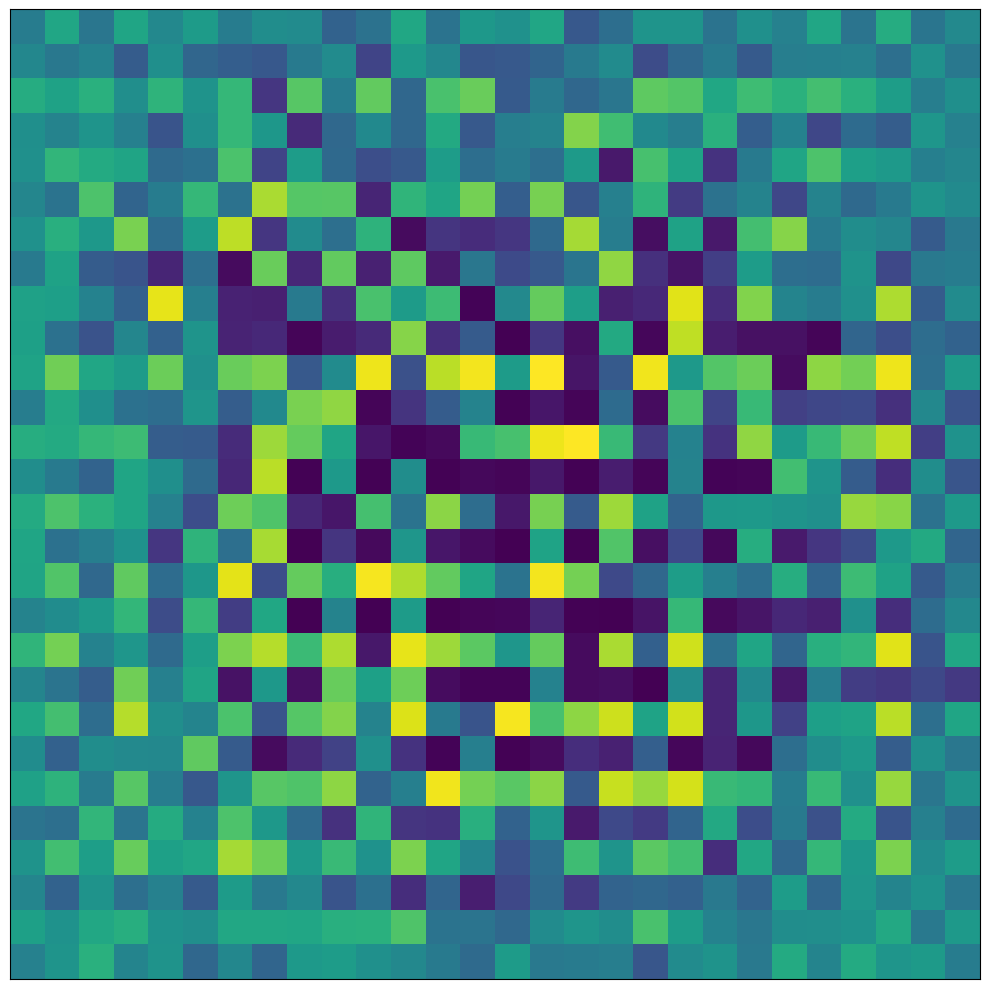

In [49]:
fig, _ = plt.subplots(figsize=(10, 10))
plt.xticks([])
plt.yticks([])
plt.imshow(decoder(torch.randn(1, dim_latent)).view(28, 28).detach().numpy())
fig.tight_layout()
plt.savefig("images/random_pixels.png")

In [5]:
# Train the Decoder and Encoder
optimizer_encoder = optim.SGD(used_encoder.parameters(), lr=0.1)
optimizer_decoder = optim.SGD(decoder.parameters(), lr=0.1)

In [7]:
# Optimizers
lr = 0.0001
enc_optim = optim.Adam(deterministic_encoder.parameters(), lr=lr)
dec_optim = optim.Adam(decoder.parameters(), lr=lr)

enc_scheduler = optim.lr_scheduler.StepLR(enc_optim, step_size=30, gamma=0.5)
dec_scheduler = optim.lr_scheduler.StepLR(dec_optim, step_size=30, gamma=0.5)

In [9]:
n_epochs = 8
lmbda = .1

used_encoder.train()
decoder.train()
reconstruction_loss = nn.MSELoss()
for epoch in range(n_epochs):
    step = 0
    for (batch, _) in tqdm(train_data_loader):
        enc_optim.zero_grad()
        dec_optim.zero_grad()

        # ======== Train Generator ======== #

        batch_size = batch.size()[0]

        if isinstance(used_encoder, DeterministicCNNEncoder): 
            z = used_encoder(batch)
        elif isinstance(used_encoder, RandomCNNEncoder): 
            z = used_encoder(batch)[0]
            """
            mean = used_encoder(images)[:, :used_encoder.dim_latent]
            logvar = used_encoder(images)[:, used_encoder.dim_latent:]
            z = mean + torch.randn_like(mean) * torch.exp(0.5 * logvar)
            """
        #print(torch.norm(z))
        x_recon = decoder(z)


        # ======== MMD Kernel Loss ======== #
        z_fake = autograd.Variable(torch.randn((batch_size, used_encoder.dim_latent)))
        distributional_loss = rbf_kernel_dist(z, z_fake)
        recon_loss = reconstruction_loss(x_recon, batch)
        total_loss = distributional_loss +  recon_loss
        total_loss.backward()
        enc_optim.step()
        dec_optim.step()
        #print(distributional_loss.item())
        # print(recon_loss.item())
    print(f"Epoch {epoch} : {total_loss.item()}")
    print(f"Reconstruction Loss : {recon_loss.item()}")
    print(f"Distributional Loss : {distributional_loss.item()}")

100%|██████████| 600/600 [03:39<00:00,  2.73it/s]


Epoch 0 : 0.21776917576789856
Reconstruction Loss : 0.07629848271608353
Distributional Loss : 0.14147070050239563


100%|██████████| 600/600 [03:28<00:00,  2.88it/s]


Epoch 1 : 0.20755425095558167
Reconstruction Loss : 0.06589066237211227
Distributional Loss : 0.1416635811328888


100%|██████████| 600/600 [03:30<00:00,  2.85it/s]


Epoch 2 : 0.20697203278541565
Reconstruction Loss : 0.06567258387804031
Distributional Loss : 0.14129944145679474


100%|██████████| 600/600 [03:27<00:00,  2.89it/s]


Epoch 3 : 0.2097356617450714
Reconstruction Loss : 0.06782563030719757
Distributional Loss : 0.14191003143787384


100%|██████████| 600/600 [03:29<00:00,  2.86it/s]


Epoch 4 : 0.20880189538002014
Reconstruction Loss : 0.06630104035139084
Distributional Loss : 0.1425008475780487


100%|██████████| 600/600 [03:24<00:00,  2.93it/s]


Epoch 5 : 0.20597350597381592
Reconstruction Loss : 0.06481756269931793
Distributional Loss : 0.14115594327449799


100%|██████████| 600/600 [03:22<00:00,  2.97it/s]


Epoch 6 : 0.20592954754829407
Reconstruction Loss : 0.06478308886289597
Distributional Loss : 0.1411464512348175


100%|██████████| 600/600 [03:26<00:00,  2.91it/s]

Epoch 7 : 0.2063608169555664
Reconstruction Loss : 0.06499407440423965
Distributional Loss : 0.14136673510074615


In [18]:
z.t().cov()

tensor([[ 0.8605,  0.1411, -0.0023,  ...,  0.0363, -0.0166, -0.0358],
        [ 0.1411,  0.6587, -0.0302,  ...,  0.1078,  0.0298, -0.0344],
        [-0.0023, -0.0302,  0.9535,  ..., -0.1119, -0.0405,  0.1002],
        ...,
        [ 0.0363,  0.1078, -0.1119,  ...,  1.3913, -0.0956, -0.1072],
        [-0.0166,  0.0298, -0.0405,  ..., -0.0956,  1.0753, -0.1100],
        [-0.0358, -0.0344,  0.1002,  ..., -0.1072, -0.1100,  0.9472]],
       grad_fn=<SqueezeBackward0>)

In [11]:
z.mean(dim=0)

tensor([-9.9562e-02,  6.7713e-02,  3.4898e-01,  1.0984e-01, -5.6213e-01,
         1.6469e-01, -5.0870e-02,  5.4236e-02,  3.1454e-02,  1.3387e-01,
        -4.6553e-02,  1.6145e-01,  9.2598e-02, -3.8592e-01, -2.4780e-01,
        -3.0905e-01, -3.0074e-01, -1.8466e-01, -3.8271e-01, -1.1295e-01,
         2.3300e-01, -6.2212e-02,  1.3342e-01, -1.0704e-01, -3.0531e-01,
        -1.1904e-01,  2.1668e-04, -6.7510e-03,  4.8419e-02, -1.4299e-02,
         4.8089e-02,  1.3807e-01, -4.2228e-01, -2.8137e-01, -2.3235e-01,
        -3.4905e-01,  4.2931e-01,  2.1117e-01, -3.3623e-01, -6.9006e-02,
         1.0671e-01,  2.4816e-01,  3.3392e-02,  3.1070e-01, -1.6072e-01,
        -7.0827e-02, -4.5872e-02, -1.8766e-02,  2.2902e-02, -1.9810e-01],
       grad_fn=<MeanBackward1>)

In [12]:
recon_loss

tensor(0.0650, grad_fn=<MseLossBackward0>)

In [13]:
rbf_kernel_dist(z, z_fake)

tensor(0.1414, grad_fn=<SumBackward0>)

In [14]:
rbf_kernel_dist(torch.randn((batch_size, used_encoder.dim_latent)), z_fake)

tensor(0.1397)

In [23]:
used_encoder.train(False)
if encoder == "deterministic": 
    encoded_images = used_encoder(testset.data.reshape(10000, 1, 28, 28) / 255.)
else: 
    encoded_images = used_encoder(testset.data.reshape(10000, 1, 28, 28) / 255.)[0]

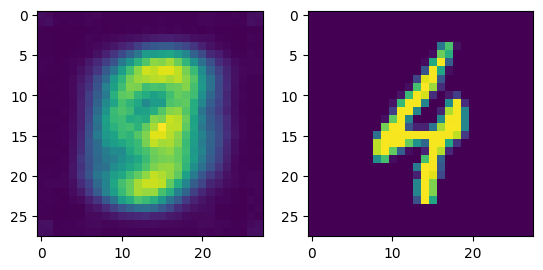

In [25]:
idx = 3672
decoder.train(False)
fig, axs = plt.subplots(nrows=1, ncols=2)
axs[1].imshow(testset[idx][0].reshape(28, 28))
if isinstance(used_encoder, DeterministicCNNEncoder): 
    axs[0].imshow(decoder(encoded_images[idx]).detach().numpy().reshape(28, 28))
elif isinstance(used_encoder, RandomCNNEncoder):
    axs[0].imshow(decoder(used_encoder(testset[idx][0].reshape(1, 1, 28, 28) / 255.)[0][0]).detach().numpy().reshape(28, 28))
#axs[0].imshow(decoder(encoded_images[idx]).detach().numpy().reshape(28, 28))

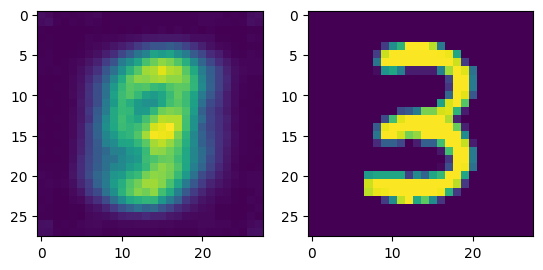

In [27]:
closest_index = torch.argmin((encoded_images[2:] - encoded_images[idx]).pow(2).sum(dim=1)) + 1
idx = closest_index

fig, axs = plt.subplots(nrows=1, ncols=2)
axs[1].imshow(testset[idx][0].reshape(28, 28))
axs[0].imshow(decoder(used_encoder(testset[idx][0].reshape(1, 1, 28, 28))[0]).detach().numpy().reshape(28, 28))

c:\Users\Q508552\GitRepos\vae-demo\.venv\Lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


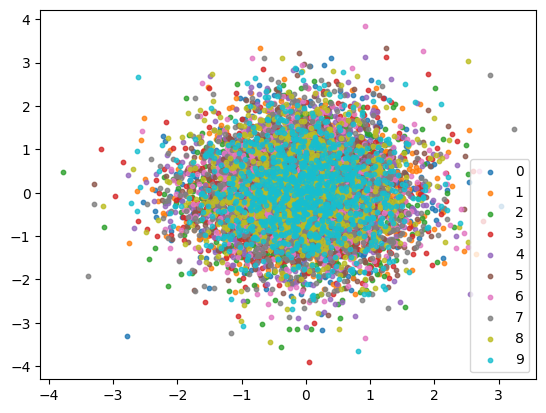

In [41]:
for i in range(10):
    curr_indices = [k for k in range(10000) if trainset.train_labels[:10000].detach().numpy()[k] == i]
    plt.scatter(encoded_images.detach().numpy()[curr_indices, 1], encoded_images.detach().numpy()[curr_indices, 3], label=str(i), alpha=0.8, s=10)

plt.legend()
plt.show()

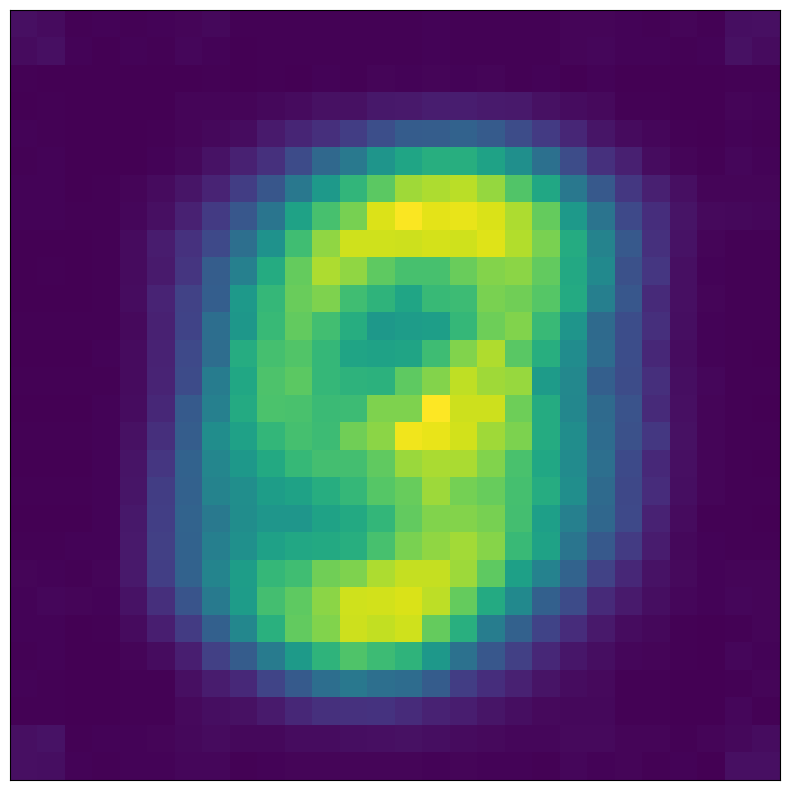

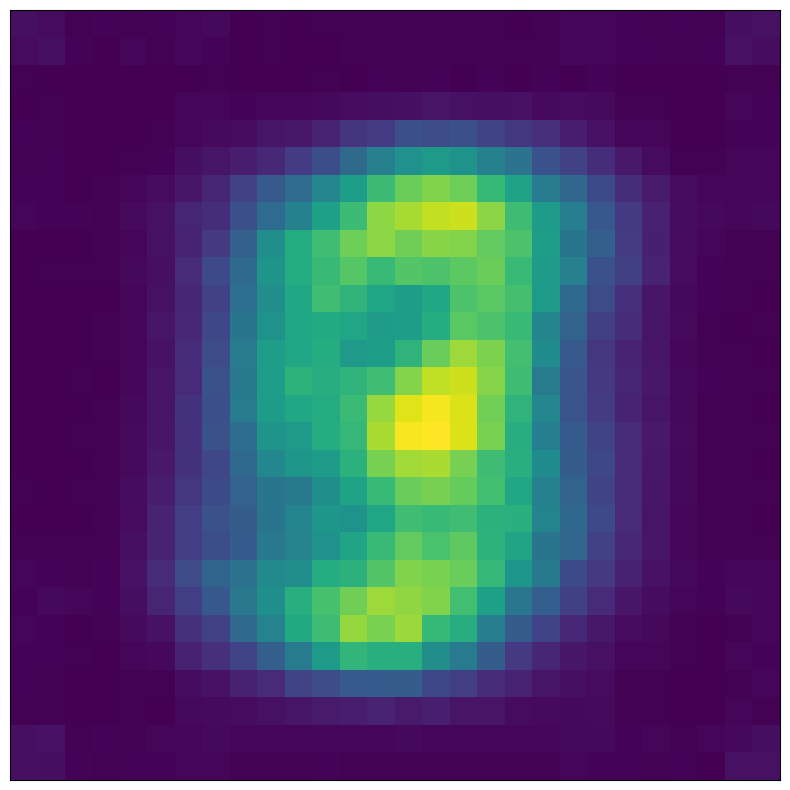

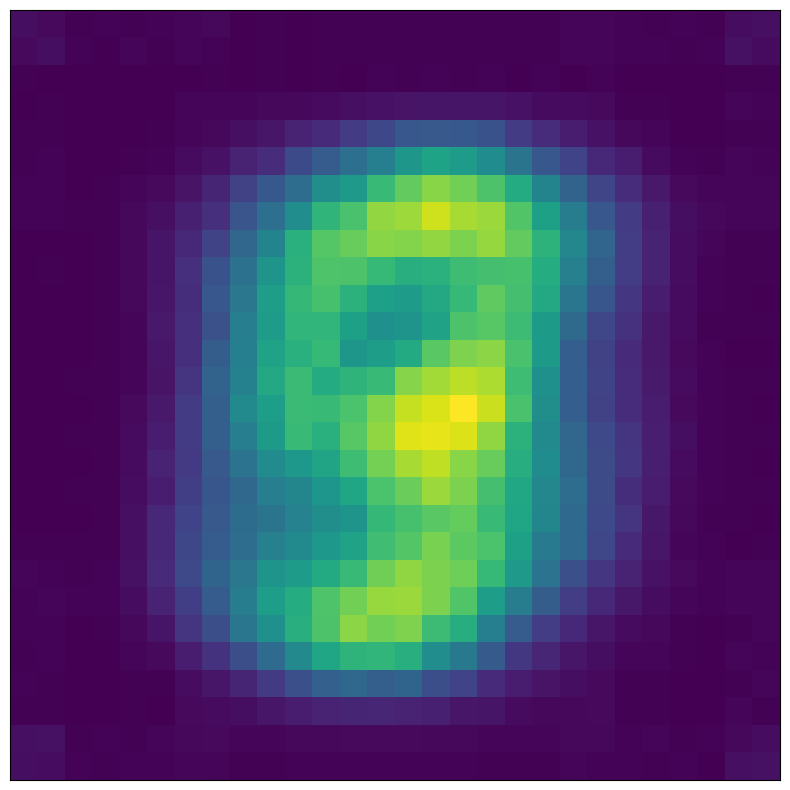

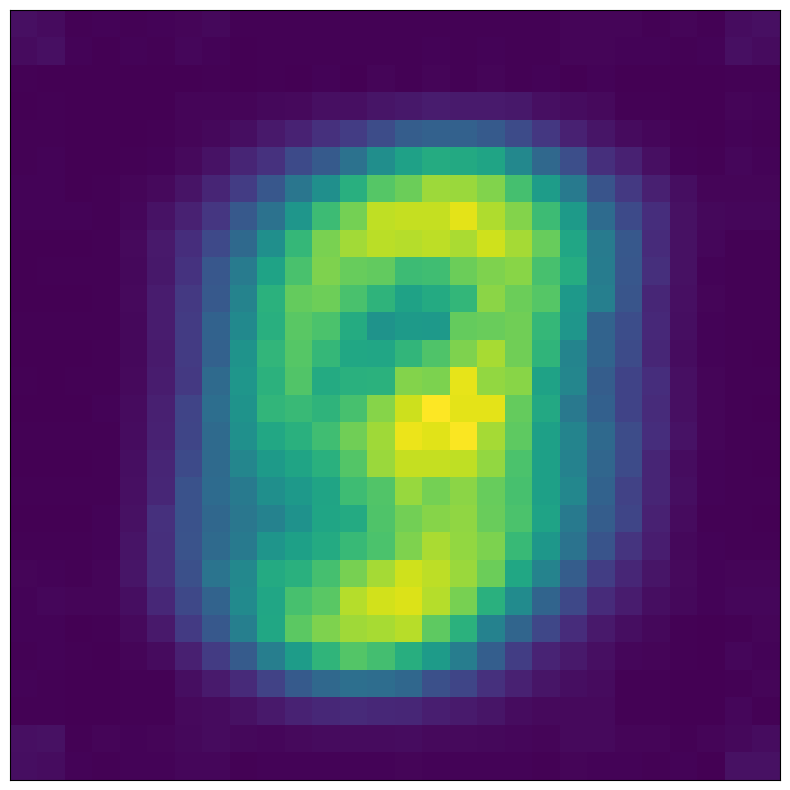

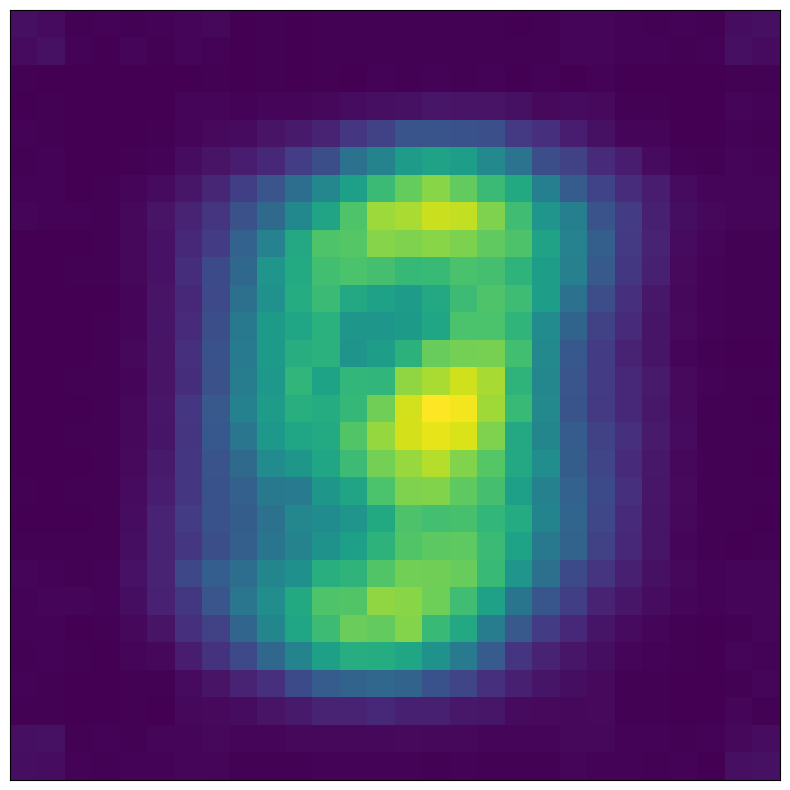

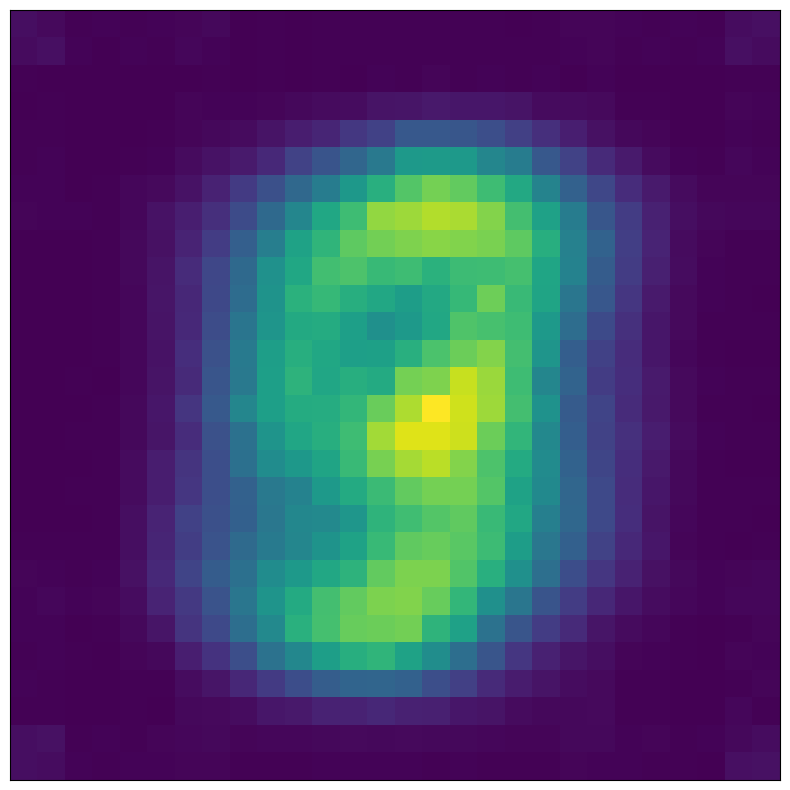

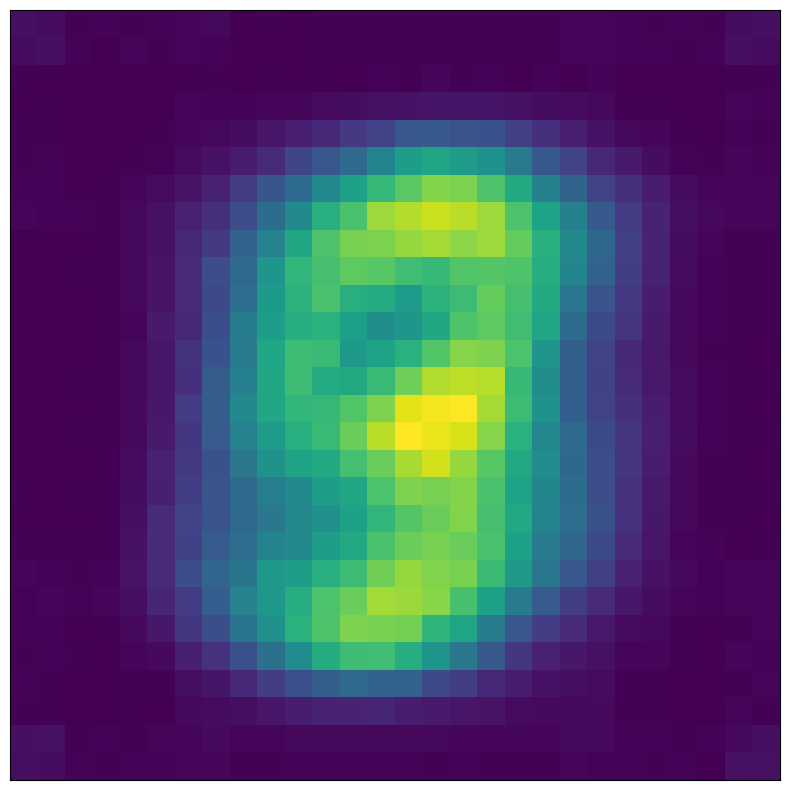

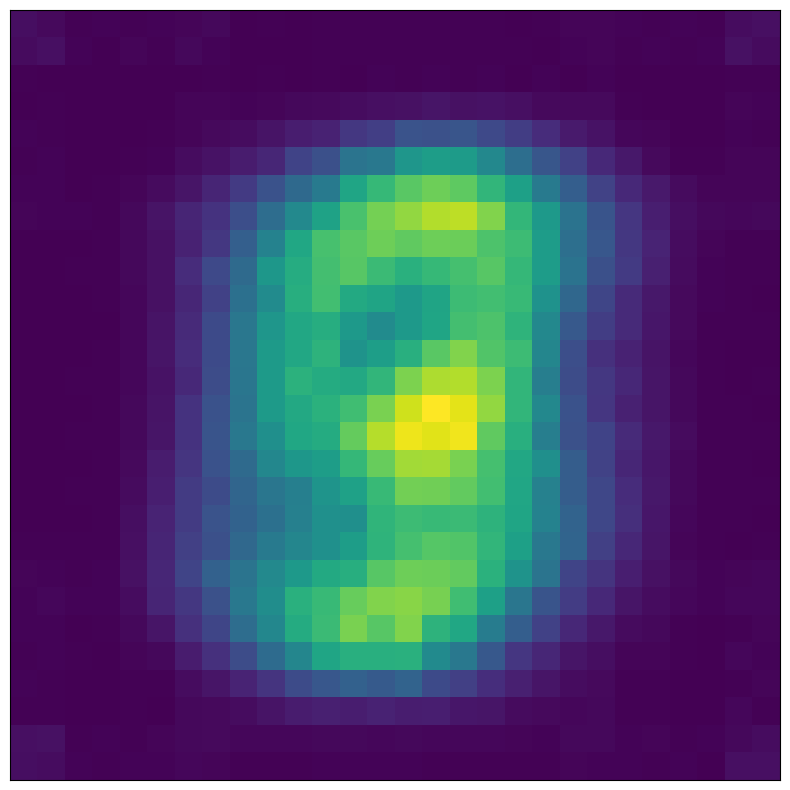

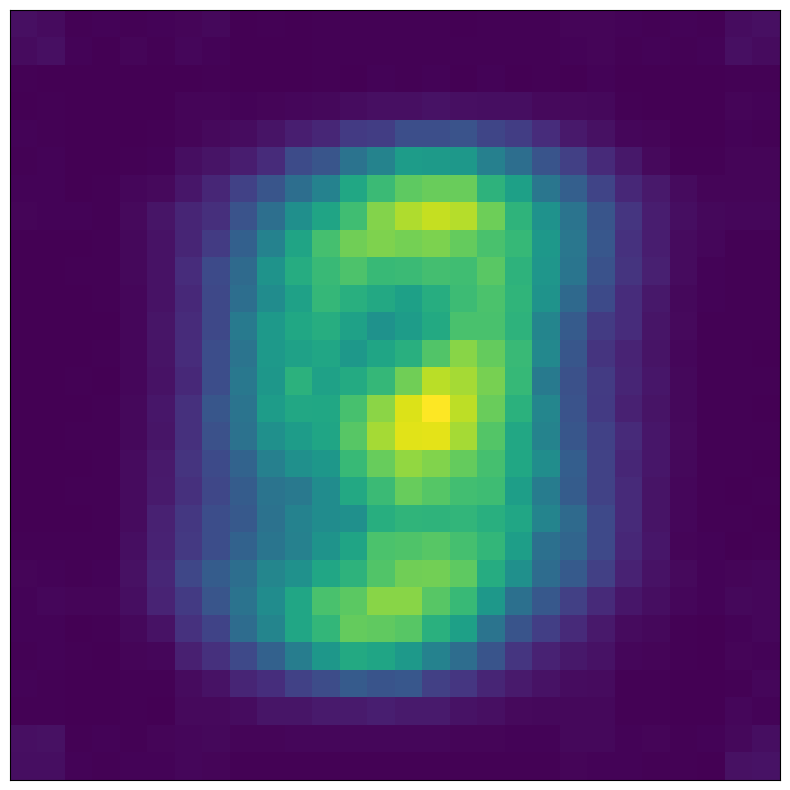

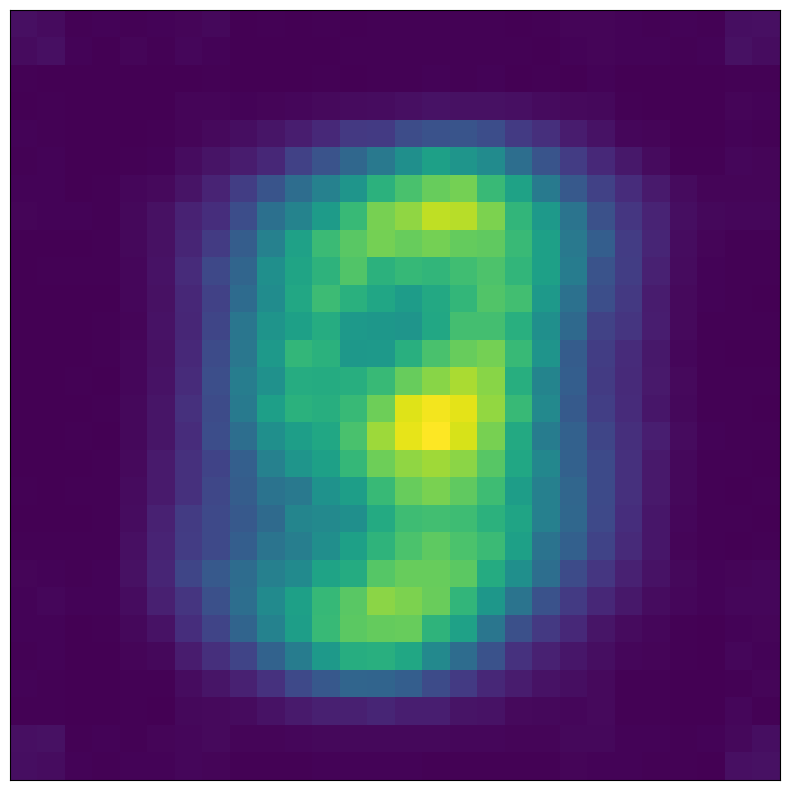

In [30]:
decoder.train(False)
n_images = 10
path = f"./images/{encoder}_{dim_latent}"
if not os.path.exists(path):
    os.makedirs(path)
for k in range(n_images): 
    plt.figure(figsize=(10, 10))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(decoder(torch.randn(1, dim_latent)).view(28, 28).detach().numpy())
    fig.tight_layout()
    plt.savefig(f"{path}/image_{k}.png")

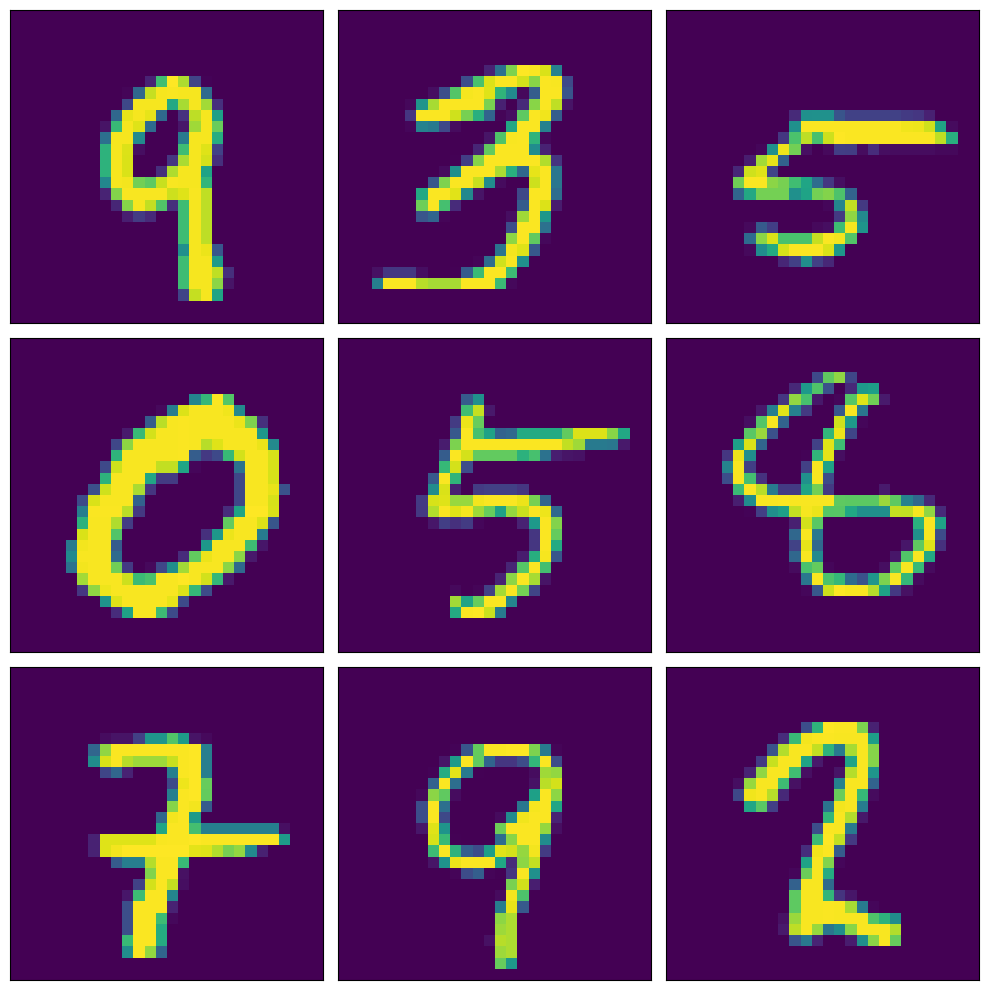

In [40]:
nrows_images = 3
ncols_images = 3

fig, _ = plt.subplots(nrows=nrows_images, ncols=ncols_images, figsize=(10, 10))
for i in range(nrows_images):
    for j in range(ncols_images):
        plt.subplot(nrows_images, ncols_images, i * ncols_images + j + 1)
        plt.xticks([])
        plt.yticks([])
        indices = torch.randperm(len(trainset))[:ncols_images * nrows_images]
        plt.imshow(trainset.data[indices[i * ncols_images + j]].numpy())
fig.tight_layout()
plt.savefig("images/mnist_example.png")